# (not done) Node Classification with Graph Neural Networks
> 공부

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [GNN]

### Import

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-05-29 15:27:00.913333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-29 15:27:00.913359: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 데이터 구성

In [146]:
_a = list()

In [147]:
for i in range(1,1001): _a.append(np.random.choice([0,1],p=[3/4,1/4],size=(1,6)))

In [148]:
ex_X = pd.DataFrame(np.array(_a).reshape(1000,6),columns = ['X1','X2','X3','X4','X5','X6'])
ex_X.shape

(1000, 6)

id의 class가 뭔지 구분할 term들 6개

In [149]:
ex_id = pd.DataFrame({'paper_id' : np.array(range(0,1000))})
ex_id.shape

(1000, 1)

id

In [176]:
ex_Y = pd.DataFrame(np.random.randint(1,3,size=(1000,1)))
ex_Y.columns = ['name']
ex_Y['subject'] = ex_Y['name'].apply(lambda x : 'Deep learning' if x == 1 else 'Reinforcement learning' )
ex_Y.shape

(1000, 2)

class = 2개

In [181]:
papers = pd.concat([ex_id,ex_X,ex_Y['subject']],axis=1)
papers

,paper_id,X1,X2,X3,X4,X5,X6,subject
0,0,0,0,0,0,0,0,Deep learning
1,1,0,0,0,0,1,0,Reinforcement learning
2,2,0,0,0,0,0,0,Deep learning
3,3,1,0,1,0,0,1,Reinforcement learning
4,4,0,0,0,1,0,1,Reinforcement learning
...,...,...,...,...,...,...,...,...
995,995,0,1,0,0,0,0,Deep learning
996,996,1,0,1,0,0,0,Reinforcement learning
997,997,0,1,1,0,0,1,Deep learning
998,998,0,0,0,0,0,0,Reinforcement learning


In [182]:
a = pd.DataFrame(np.random.choice(range(0,1000),size=(2500,1)))
b = pd.DataFrame(np.random.choice(range(0,1000),size=(2500,1)))

In [183]:
citations = pd.concat([a,b],axis=1)
citations.columns = ['target','source']
citations

,target,source
0,831,243
1,203,254
2,349,855
3,236,645
4,872,835
...,...,...
2495,785,366
2496,917,330
2497,19,121
2498,90,120


### 그래프 표현

In [186]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

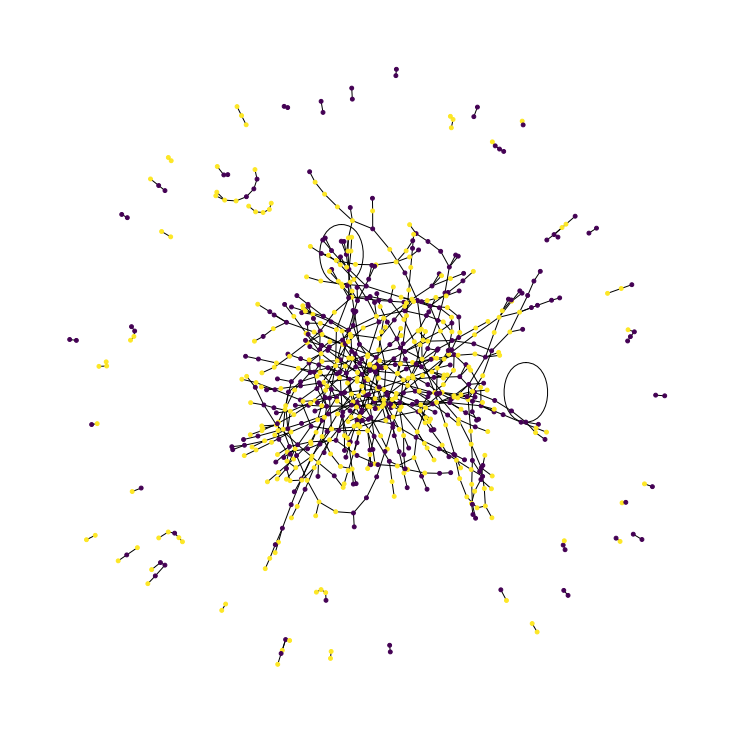

In [188]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=800))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

### Test vs Train

In [189]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (493, 8)
Test data shape: (507, 8)


In [190]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [191]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [192]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [193]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [194]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [195]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 6)]          0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           1432        ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [196]:
x_train

array([[0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       ...,
       [1, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0]])

In [197]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
2/2 [==============================] - 2s 259ms/step - loss: 3.2142 - acc: 0.5036 - val_loss: 0.8038 - val_acc: 0.4459
Epoch 2/300
2/2 [==============================] - 0s 31ms/step - loss: 1.3940 - acc: 0.4988 - val_loss: 0.9372 - val_acc: 0.4459
Epoch 3/300
2/2 [==============================] - 0s 32ms/step - loss: 1.6366 - acc: 0.4940 - val_loss: 0.9471 - val_acc: 0.4459
Epoch 4/300
2/2 [==============================] - 0s 33ms/step - loss: 1.6738 - acc: 0.5179 - val_loss: 0.8750 - val_acc: 0.4459
Epoch 5/300
2/2 [==============================] - 0s 40ms/step - loss: 1.3162 - acc: 0.4988 - val_loss: 0.8036 - val_acc: 0.4459
Epoch 6/300
2/2 [==============================] - 0s 37ms/step - loss: 1.0819 - acc: 0.4964 - val_loss: 0.7580 - val_acc: 0.4459
Epoch 7/300
2/2 [==============================] - 0s 39ms/step - loss: 1.2500 - acc: 0.4845 - val_loss: 0.7343 - val_acc: 0.4459
Epoch 8/300
2/2 [==============================] - 0s 41ms/step - loss: 1.2303 - acc: 0.5

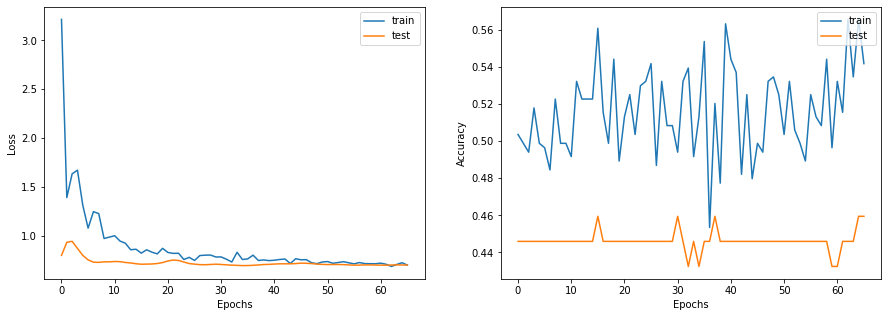

In [198]:
display_learning_curves(history)

In [199]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 48.72%


### baseline 모델 예측

In [200]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [201]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- Deep learning: 55.67%
- Reinforcement learning: 44.33%
Instance 2:
- Deep learning: 56.73%
- Reinforcement learning: 43.27%


In [202]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 2500)
Nodes shape: (1000, 6)


In [203]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, aggregated_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [204]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [205]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

NameError: Exception encountered when calling layer "graph_conv1" (type GraphConvLayer).

name 'neighbour_messages' is not defined

Call arguments received:
  • inputs=('tf.Tensor(shape=(1000, 32), dtype=float32)', 'tf.Tensor(shape=(2, 2500), dtype=int64)', 'tf.Tensor(shape=(2500,), dtype=float32)')

### 데이터 구성